<a href="https://colab.research.google.com/github/toby-j/fyp_concept/blob/master/pytorchIG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First implementation

In [23]:
!pip install pafy
!pip install youtube-dl
!pip install --upgrade youtube-dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import numpy as np
import cv2
import pafy
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

import torch
from torch import nn
from torchvision import transforms

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

/usr/local/lib/python3.9/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(

In [25]:
class ObjectDetectionPipeline:
    def __init__(self, threshold=0.5, device="cpu", cmap_name="tab10_r"):
        # First we need a Transform object to turn numpy arrays to normalised tensors.
        # We are using an SSD300 model that requires 300x300 images.
        # The normalisation values are standard for pretrained pytorch models.
        self.tfms = transforms.Compose([
            transforms.Resize(300),
            transforms.CenterCrop(300),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
        # Next we need a model. We're setting it to evaluation mode and sending it to the correct device.
        # We get some speedup from the gpu but not as much as we could.
        # A more efficient way to do this would be to collect frames to a buffer,
        # run them through the network as a batch, then output them one by one
        self.model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd').eval().to(device)
        
        # Stop the network from keeping gradients.
        # It's not required but it gives some speedup / reduces memory use.
        for param in self.model.parameters():
            param.requires_grad = False
        
        
        self.device = device
        self.threshold = threshold # Confidence threshold for displaying boxes.
        self.cmap = cm.get_cmap(cmap_name) # colour map
        self.classes_to_labels = utils.get_coco_object_dictionary()

    
    @staticmethod
    def _crop_img(img):
        """Crop an image or batch of images to square"""
        if len(img.shape) == 3:
            y = img.shape[0]
            x = img.shape[1]
        elif len(img.shape) == 4:
            y = img.shape[1]
            x = img.shape[2]
        else:
            raise ValueError(f"Image shape: {img.shape} invalid")
            
        out_size = min((y, x))
        startx = x // 2 - out_size // 2
        starty = y // 2 - out_size // 2
        
        if len(img.shape) == 3:
            return img[starty:starty+out_size, startx:startx+out_size]
        elif len(img.shape) == 4:
            return img[:, starty:starty+out_size, startx:startx+out_size]
        
    def _plot_boxes(self, output_img, labels, boxes):
        """Plot boxes on an image"""
        for label, (x1, y1, x2, y2) in zip(labels, boxes):
            if (x2 - x1) * (y2 - y1) < 0.25:
                # The model seems to output some large boxes that we know cannot be possible.
                # This is a simple rule to remove them.
            
                x1 = int(x1*output_img.shape[1])
                y1 = int(y1*output_img.shape[0])
                x2 = int(x2*output_img.shape[1])
                y2 = int(y2*output_img.shape[0])
            
                rgba = self.cmap(label)
                bgr = rgba[2]*255, rgba[1]*255, rgba[0]*255
                cv2.rectangle(output_img, (x1, y1), (x2, y2), bgr, 2)
                cv2.putText(output_img, self.classes_to_labels[label - 1], (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 2)
            
        return output_img
    
    def __call__(self, img):
        """
        Now the call method This takes a raw frame from opencv finds the boxes and draws on it.
        """
        if type(img) == np.ndarray:
            # single image case
            
            # First convert the image to a tensor, reverse the channels, unsqueeze and send to the right device.
            img_tens = self.tfms(Image.fromarray(img[:,:,::-1])).unsqueeze(0).to(self.device)
        
            # Run the tensor through the network.
            # We'll use NVIDIAs utils to decode.
            results = utils.decode_results(self.model(img_tens))
            boxes, labels, conf = utils.pick_best(results[0], self.threshold)
        
            # Crop the image to match what we've been predicting on.
            output_img = self._crop_img(img)
        
            return self._plot_boxes(output_img, labels, boxes)
        
        elif type(img) == list:
            # batch case
            if len(img) == 0:
                # Catch empty batch case
                return None
            
            tens_batch = torch.cat([self.tfms(Image.fromarray(x[:,:,::-1])).unsqueeze(0) for x in img]).to(self.device)
            results = utils.decode_results(self.model(tens_batch))
            
            output_imgs = []
            for im, result in zip(img, results):
                boxes, labels, conf = utils.pick_best(result, self.threshold)
                output_imgs.append(self._plot_boxes(self._crop_img(im), labels, boxes))
                
            return output_imgs
        
        else:
            raise TypeError(f"Type {type(img)} not understood")

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<ipython-input-25-4b0d24919fcf>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = cm.get_cmap(cmap_name) # colour map


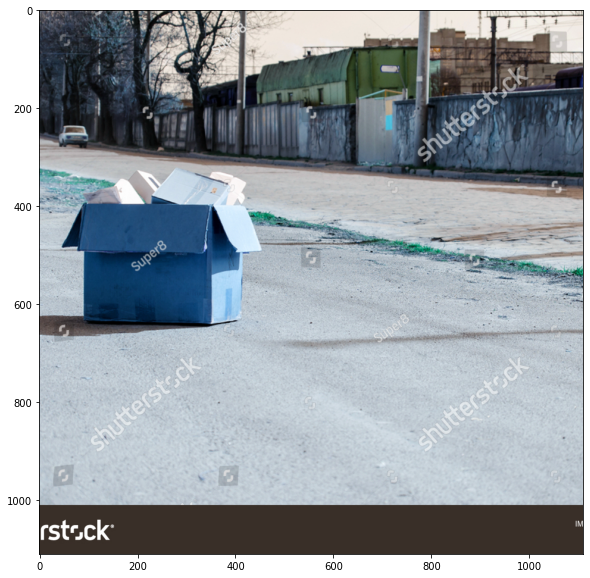

In [26]:
obj_detect = ObjectDetectionPipeline(device="cpu", threshold=0.5)

im = Image.open('frame.jpg')

im = np.asarray(im)
im = im[:, :, :3]

plt.figure(figsize=(10,10))

plt.imshow(obj_detect(im)[:,:,::-1])

plt.show()

# Second Implementation

In [101]:
import torch
import torchvision
import pycocotools
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

frame = Image.open('frame.png')
# Converting frame to tensor
frame = frame.convert("RGB")
frame = pil_to_tensor(frame)

# Add dimension at beginning of image which is the batch dimension
print(frame.shape) 
frame_int = frame.unsqueeze(dim=0)
print("added dimension")
print(type(frame_int))
print(frame_int.shape)
# We need to represent then as float tensors. So we divide by 255 so we get float vectors. We use the int tensors for plotting the bounding box
frame_float = frame_int / 255.0

torch.Size([3, 281, 473])
added dimension
<class 'torch.Tensor'>
torch.Size([1, 3, 281, 473])


In [102]:
object_detection_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
object_detection_model.eval(); ## Setting Model for Evaluation/Prediction

In [103]:
frame_preds = object_detection_model(frame_float)

In [104]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

--2023-03-19 20:05:18--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.165.225, 52.216.163.27, 3.5.16.2, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.165.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.4’

annotations_trainva 100%[===================>] 241.19M  13.3MB/s    in 20s     

2023-03-19 20:05:39 (12.0 MB/s) - ‘annotations_trainval2017.zip.4’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
replace annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [105]:
from pycocotools.coco import COCO
annFile='annotations/instances_val2017.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=1.03s)
creating index...
index created!


In [106]:
frame_labels = coco.loadCats(frame_preds[0]["labels"].numpy())

In [148]:
from torchvision.utils import draw_bounding_boxes

# annot_labels = ["{}-{:.2f}".format(label["name"], prob) for label, prob in zip(frame_labels, frame_preds[0]["scores"].detach().numpy())]

# Going to remove duplicates, not sure if it's the model that's causing this. If it is, this implementation is fine

# holiday_annot_labels = ["{}-{:.2f}".format(label["name"], prob) for label, prob in zip(frame_labels, frame_preds[0]["scores"].detach().numpy())]

annot_labels = []
# Removing noise by only adding probabbility above 0.1 and avoiding duplicate classifications.
for i, (label, prob) in enumerate(zip(frame_labels, frame_preds[0]["scores"].detach().numpy())):
  # Check if annot contains ID already
  if (prob > 0.1 and label['id'] not in annot_labels):
    annot_labels.append("{}-{:.2f}".format(label["name"], prob))
  else:
    # Removing boxes based on the index we're looking at
    frame_preds[0]["boxes"] = torch.cat([frame_preds[0]["boxes"][:i], frame_preds[0]["boxes"][i+1:]], dim=0)

    
print(annot_labels)

print(frame_preds)
print(frame_preds[0]['scores'])

holiday_output = draw_bounding_boxes(image=frame_int[0],
                             boxes=frame_preds[0]["boxes"],
                             labels=annot_labels,
                             colors=["red" if label["name"]=="person" else "green" for label in frame_labels],
                             width=2
                            )

holiday_output.shape

{'supercategory': 'person', 'id': 1, 'name': 'person'}
{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}
{'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehi

ValueError: ignored

<class 'torch.Tensor'>


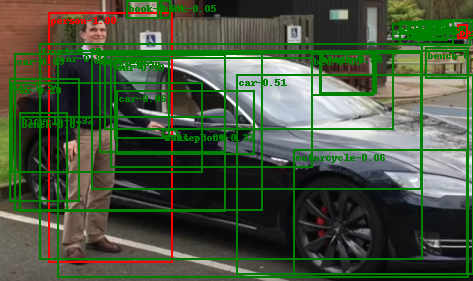

In [140]:
from torchvision.transforms.functional import to_pil_image

print(type(holiday_output))
to_pil_image(holiday_output)

# Scratch OD